In [1]:
from typing import Literal, List, TypedDict, Optional
from langgraph.graph import StateGraph, END

# 최신 추천 import: 전용 패키지
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_ollama import ChatOllama
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


/opt/homebrew/Caskroom/miniforge/base/envs/langchain/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --------------- 1) 상태 정의 ---------------

class ChatState(TypedDict, total=False):
    user_input: str
    mode: Literal["counsel", "info", "save", "end"]
    response: str
    history: List[str]
    saved_notes: List[str]   # 논리적 기록용 (옵션)

# --------------- 2) LLM & 벡터스토어 준비 ---------------

# 공통 LLM (ChatOllama) – 톤은 프롬프트로 조절
llm_base = ChatOllama(model="qwen3:8b")
llm_counsel = llm_base
llm_info    = llm_base

# 임베딩 모델
embedding = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

PERSIST_DIR = "./note_store"

# Chroma 벡터스토어 생성 / 로드
vectorstore = Chroma(
    collection_name="user_notes",
    embedding_function=embedding,
    persist_directory=PERSIST_DIR,
)

In [3]:
# --------------- 2-1) RAG 체인 구성 (최신 LCEL 방식) ---------------

# RAG용 프롬프트 정의
rag_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "다음 컨텍스트를 사용해서 사용자의 질문에 한국어로 간결하게 답하라. "
            "모르면 모른다고 말하라.\n\n컨텍스트:\n{context}"
        ),
        ("human", "{question}"),
    ]
)

# 검색된 문서들을 하나의 문자열로 합치는 함수
def format_docs(docs: List[Document]) -> str:
    return "\n\n".join(doc.page_content for doc in docs)

# Retriever 생성
retriever = vectorstore.as_retriever()

# LCEL로 RAG 체인 구성
# 입력: "질문 문자열"
# 내부 흐름:
#   - context: retriever로 문서 검색 → format_docs
#   - question: 그대로 전달
#   - rag_prompt: context + question으로 프롬프트 생성
#   - llm_info: LLM 호출
#   - StrOutputParser: 최종 문자열만 반환
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough(),
    }
    | rag_prompt
    | llm_info
    | StrOutputParser()
)

# --------------- 2-2) Router용 프롬프트 & LLM 분류 함수 ---------------

router_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "너는 사용자 요청을 보고 아래 네 가지 모드 중 하나로 분류하는 라우터야.\n"
                "- 'counsel': 상담/감정/고민/위로가 필요한 경우\n"
                "- 'info': 객관적인 정보/사실/설명을 요청하는 경우\n"
                "- 'save': 사용자가 어떤 내용을 '저장', '기억', '메모' 하라고 말하는 경우\n"
                "- 'end': 대화를 끝내고 싶을 때 (예: 종료, 그만, quit 등)\n\n"
                "이전 모드(prev_mode)도 참고해서 문맥을 유지해.\n"
                "반드시 아래 네 단어 중 하나만 소문자 영어로 출력해:\n"
                "counsel, info, save, end"
            ),
        ),
        (
            "human",
            "이전 모드: {prev_mode}\n사용자 입력: {user_input}\n\n모드:"
        ),
    ]
)

def classify_mode_with_llm(user_input: str, prev_mode: Optional[str]) -> str:
    """LLM을 사용해서 모드를 결정 (counsel/info/save/end)"""
    messages = router_prompt.format_messages(
        prev_mode=prev_mode or "none",
        user_input=user_input,
    )
    result = llm_base.invoke(messages)
    raw = result.content.strip().lower()
    print(f"[DEBUG][router_llm] raw mode = {raw!r}")

    if "counsel" in raw:
        return "counsel"
    if "save" in raw:
        return "save"
    if "end" in raw:
        return "end"
    if "info" in raw:
        return "info"
    # 이상한 답 나오면 기본값은 info
    return "info"


In [4]:
# --------------- 3) 노드 정의 ---------------

END_WORDS = ("끝", "종료", "quit", "exit")

def router(state: ChatState) -> ChatState:
    """대표 비서: 입력과 이전 모드를 보고 어떤 기능으로 보낼지 결정"""
    user_input = state.get("user_input", "")
    text = user_input.strip()
    prev_mode = state.get("mode")

    print(f"[DEBUG][router] 입력: {user_input!r}")

    # 1) 완전 빈 입력이면 종료
    if not text:
        mode: Literal["end"] = "end"

    # 2) 강제 종료 키워드는 안전하게 하드코딩
    elif text in END_WORDS:
        mode = "end"

    # 3) 이전 모드가 상담이고, 사용자가 명시적으로 상담 종료 의사를 밝히지 않으면 상담 유지
    elif prev_mode == "counsel" and not any(
        kw in text for kw in ("상담 종료", "상담을 종료", "상담 그만", "그만 상담")
    ):
        mode = "counsel"

    # 4) 그 외 경우는 LLM에게 맡김
    else:
        mode_str = classify_mode_with_llm(text, prev_mode)
        mode = mode_str  # type: ignore[assignment]

    next_state: ChatState = dict(state)
    next_state["mode"] = mode
    print(f"[DEBUG][router] 최종 mode = {mode}")
    return next_state

def counsel_node(state: ChatState) -> ChatState:
    """부드러운 톤의 상담 선생님"""
    user_input = state.get("user_input", "")

    system_prompt = (
        "당신은 따뜻하고 공감해주는 한국어 상담 선생님입니다. "
        "항상 부드러운 말투로 위로와 공감을 전해 주세요."
    )
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_input),
    ]
    result = llm_counsel.invoke(messages)
    reply = result.content

    new_state: ChatState = dict(state)
    new_state["response"] = reply
    history = list(new_state.get("history", []))
    history.append(f"사용자: {user_input}")
    history.append(f"상담: {reply}")
    new_state["history"] = history
    return new_state

def info_node(state: ChatState) -> ChatState:
    """객관적인 정보 제공자 - 저장된 텍스트(벡터 DB) 기반으로 답변"""
    user_input = state.get("user_input", "")

    # 최신 RAG 체인 호출 (입력: 질문 문자열)
    reply = rag_chain.invoke(user_input)

    new_state: ChatState = dict(state)
    new_state["response"] = reply
    history = list(new_state.get("history", []))
    history.append(f"사용자: {user_input}")
    history.append(f"정보(RAG): {reply}")
    new_state["history"] = history
    return new_state

def save_node(state: ChatState) -> ChatState:
    """사용자 문장을 벡터 DB에 저장"""
    user_input = state.get("user_input", "")

    to_save = user_input.replace("저장", "", 1).strip() or user_input

    doc = Document(page_content=to_save, metadata={"source": "user_note"})
    vectorstore.add_documents([doc])

    reply = f"[SYSTEM] 입력하신 내용이 벡터 DB에 저장되었습니다: \"{to_save}\""

    new_state: ChatState = dict(state)
    saved = list(new_state.get("saved_notes", []))
    saved.append(to_save)
    new_state["saved_notes"] = saved

    new_state["response"] = reply
    history = list(new_state.get("history", []))
    history.append(f"저장됨(벡터DB): {to_save}")
    new_state["history"] = history
    return new_state

# --------------- 4) 그래프 구성 ---------------

def build_graph():
    graph = StateGraph(ChatState)

    graph.add_node("router", router)
    graph.add_node("counsel", counsel_node)
    graph.add_node("info", info_node)
    graph.add_node("save", save_node)

    graph.set_entry_point("router")

    def route_mode(state: ChatState) -> str:
        return state["mode"]

    graph.add_conditional_edges(
        "router",
        route_mode,
        {
            "counsel": "counsel",
            "info": "info",
            "save": "save",
            "end": END,
        },
    )

    # 각 기능 노드는 한 번 실행 후 종료(END)로 처리 (back-edge 없음)
    return graph.compile()

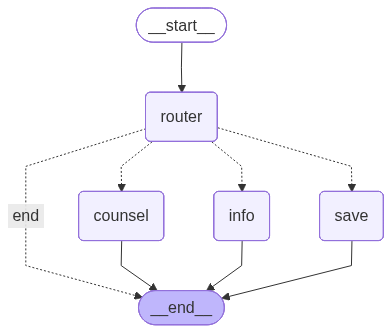

In [5]:
app = build_graph()
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# --------------- 5) 메인 루프 (터미널 챗봇) ---------------
if __name__ == "__main__":

    state: ChatState = {
        "user_input": "",
        "mode": "info",   # 초기 모드
        "history": [],
        "saved_notes": [],
    }

    print("멀티 에이전트 비서 챗봇입니다.")
    print("'상담 ...'으로 상담을 시작할 수 있고, '상담 종료' 같은 표현으로 상담을 마칠 수 있습니다.")
    print("'저장 ...' 또는 저장 관련 자연어로 메모를 저장할 수 있고, '종료'로 프로그램을 끝낼 수 있습니다.")

    while True:
        user_input = input("사용자> ").strip()
        if user_input in END_WORDS:
            print("봇> 대화를 종료합니다. 이용해 주셔서 감사합니다.")
            break

        state["user_input"] = user_input
        state = app.invoke(state)

        print("봇 >", state.get("response", ""))

        # DEBUG: 현재 모드만 출력
        print(f"[DEBUG] 현재 mode: {state.get('mode')}")
        print("-" * 50)

멀티 에이전트 비서 챗봇입니다.
'상담 ...'으로 상담을 시작할 수 있고, '상담 종료' 같은 표현으로 상담을 마칠 수 있습니다.
'저장 ...' 또는 저장 관련 자연어로 메모를 저장할 수 있고, '종료'로 프로그램을 끝낼 수 있습니다.
